In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
print(tf.__version__)

2.11.0


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory( 
    "plantVillage", 
    seed =123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())    

(32, 256, 256, 3)
[1 1 0 1 0 1 1 1 1 0 2 1 1 0 1 0 0 1 0 0 1 1 1 2 1 0 1 1 1 0 0 0]


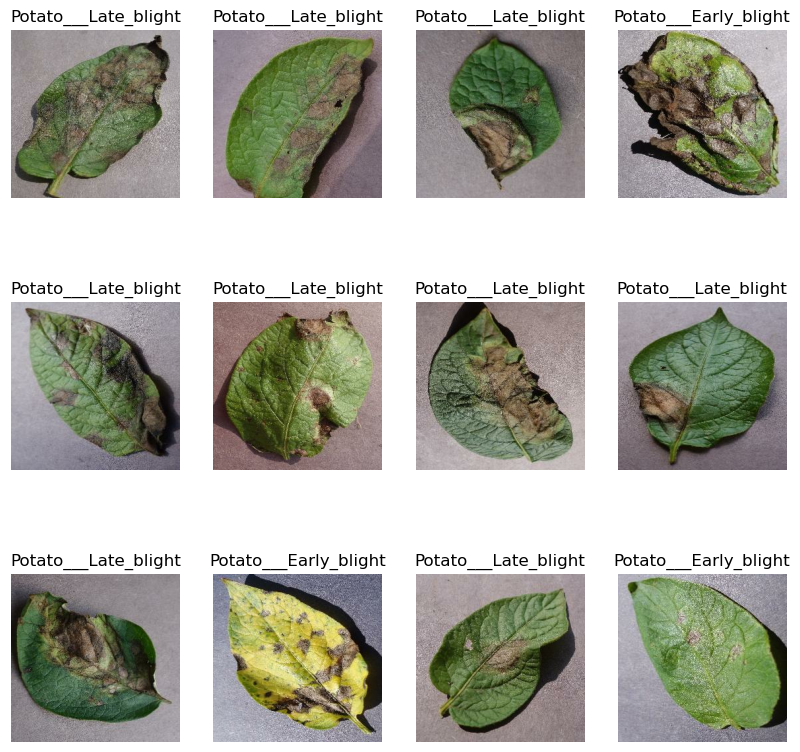

In [14]:
plt.figure(figsize = (10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_name[labels_batch[i]])
        plt.axis('off')

In [15]:
len(dataset)

68

In [17]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [19]:
train_ds = dataset.take(54)

In [21]:
len(train_ds)

54

In [22]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [23]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [24]:
val_ds = test_ds.take(6)

In [25]:
len(val_ds)

6

In [26]:
test_ds = test_ds.skip(6)

In [28]:
len(test_ds)

8

In [30]:
def get_dataset_pertitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+test_split+val_split) ==1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [31]:
train_ds, val_ds, test_ds = get_dataset_pertitions_tf(dataset)

In [32]:
len(train_ds)

54

In [33]:
len(val_ds)

6

In [34]:
len(test_ds)

8

In [36]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [37]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [40]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [43]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True),y)).prefetch(buffer_size= tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [46]:
model.build(input_shape = input_shape)

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [50]:
model.compile(
    optimizer= 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs = 16,
)

Epoch 1/16
54/54 [==============================] - 83s 2s/step - loss: 0.3875 - accuracy: 0.8275 - val_loss: 1.1256 - val_accuracy: 0.6927
Epoch 2/16
54/54 [==============================] - 83s 2s/step - loss: 0.3112 - accuracy: 0.8825 - val_loss: 0.4976 - val_accuracy: 0.7917
Epoch 3/16
54/54 [==============================] - 83s 2s/step - loss: 0.2395 - accuracy: 0.9155 - val_loss: 0.7697 - val_accuracy: 0.7552
Epoch 4/16
54/54 [==============================] - 84s 2s/step - loss: 0.2744 - accuracy: 0.8981 - val_loss: 1.1926 - val_accuracy: 0.7188
Epoch 5/16
54/54 [==============================] - 83s 2s/step - loss: 0.2215 - accuracy: 0.9057 - val_loss: 0.2542 - val_accuracy: 0.8958
Epoch 6/16
54/54 [==============================] - 84s 2s/step - loss: 0.2142 - accuracy: 0.9213 - val_loss: 0.5895 - val_accuracy: 0.7969
Epoch 7/16
54/54 [==============================] - 85s 2s/step - loss: 0.1157 - accuracy: 0.9583 - val_loss: 0.1734 - val_accuracy: 0.9479
Epoch 8/16
54/54 [==

In [59]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 294ms/step - loss: 0.0919 - accuracy: 0.9688


In [60]:
history.params

{'verbose': 1, 'epochs': 16, 'steps': 54}

In [61]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [64]:
for i in history.history.keys():
    p = type(history.history[i])
    print(i,p)

loss <class 'list'>
accuracy <class 'list'>
val_loss <class 'list'>
val_accuracy <class 'list'>


In [65]:
acc = history.history['accuracy']

In [67]:
val_acc = history.history['val_accuracy']

In [68]:
loss = history.history['loss']

In [69]:
val_loss  = history.history['val_loss']

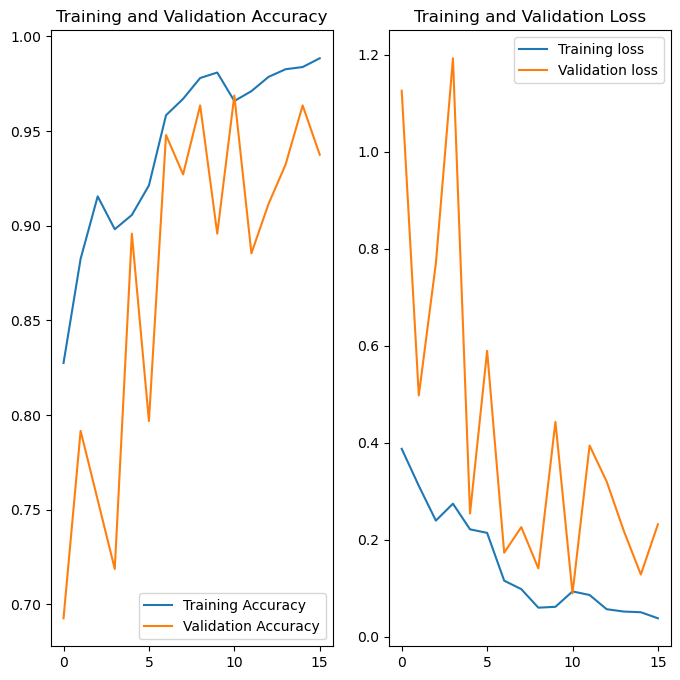

In [74]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(16), acc, label = 'Training Accuracy')
plt.plot(range(16), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(16), loss, label = 'Training loss')
plt.plot(range(16), val_loss, label = "Validation loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

First Image to predict
actual label:  Potato___Early_blight
1/1 [==============================] - 0s 297ms/step
predicted label:  Potato___Late_blight


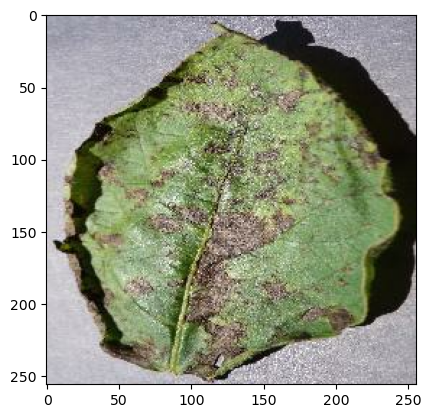

In [78]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy().astype('uint8')
    
    print('First Image to predict')
    plt.imshow(first_image)
    print("actual label: ", class_name[first_label])
    
    batch_predection = model.predict(image_batch)
    print('predicted label: ', class_name[np.argmax(batch_predection[0])])

In [86]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_name[np.argmax(predictions[0])]
    cofidence = round(100*(np.max(predictions[0])), 2)
    
    return predicted_class, cofidence

1/1 [==============================] - 0s 28ms/step


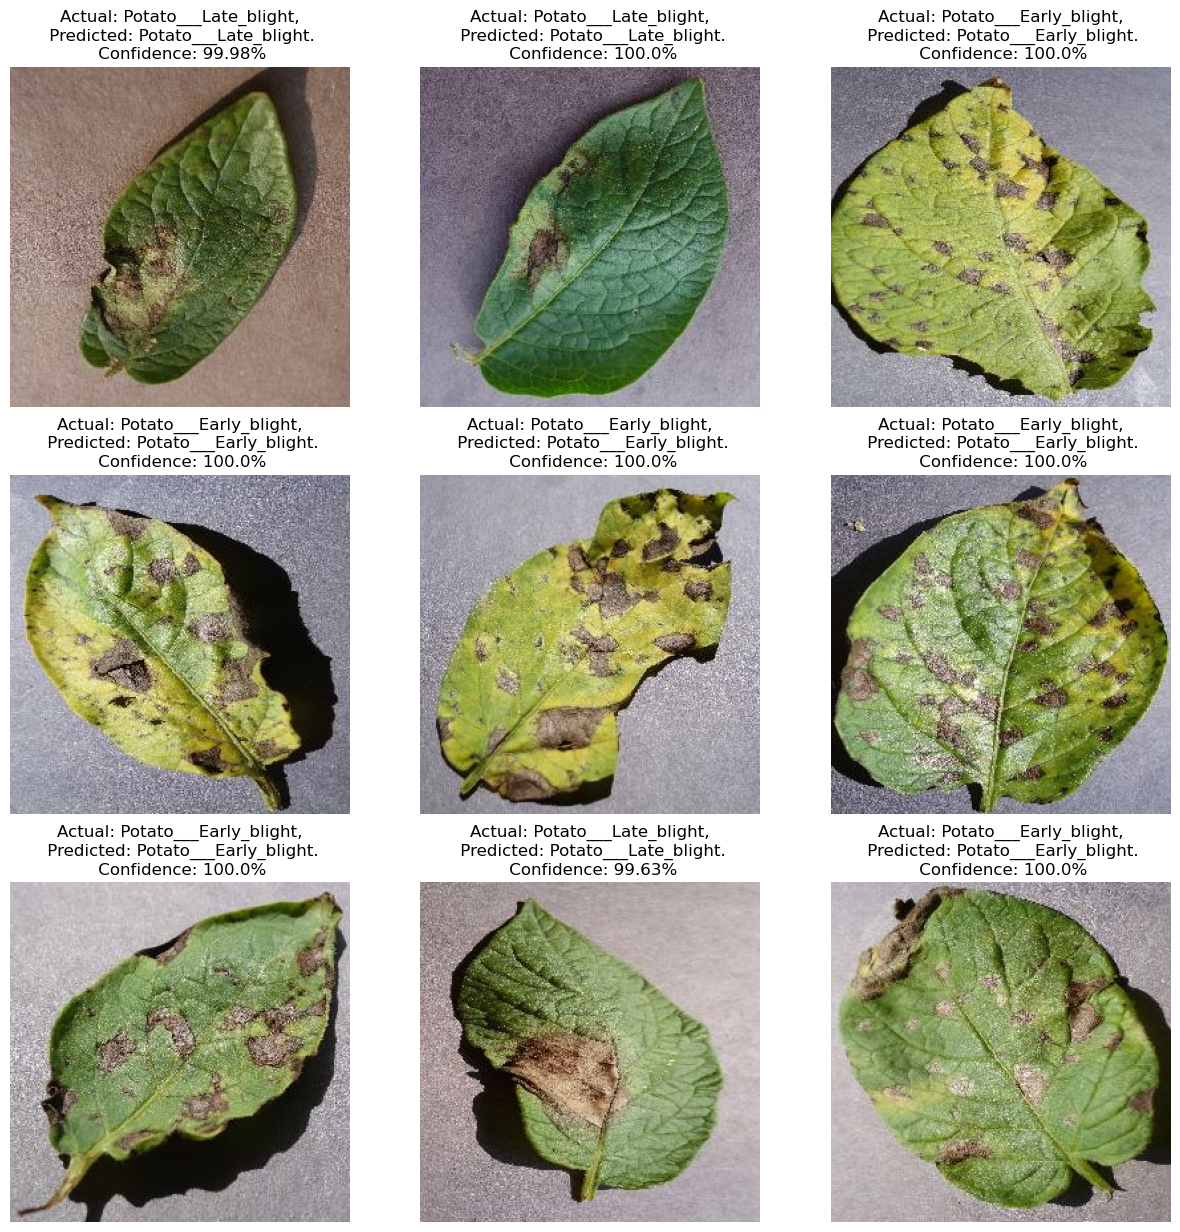

In [88]:
"""plt.figure(figsize = (15, 15))

for images, labels, in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual :{actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')"""

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [57]:


import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")



INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [58]:
model.save("../potatoes.h5")